## Load Packages

In [213]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
import os
import shutil
import random
import collections
import tifffile as tiff
from sklearn.model_selection import train_test_split
import cv2
import albumentations as A
import warnings
warnings.filterwarnings("ignore")
# Check if GPU is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Print GPU details
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu in gpu_devices:
        print("Device:", gpu)
else:
    print("No GPU found. Make sure GPU is enabled in Kaggle settings.")
# Set TensorFlow to run on GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU enabled for TensorFlow!")
    except RuntimeError as e:
        print(e)

Num GPUs Available: 1
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU enabled for TensorFlow!


In [214]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [215]:
import rasterio
file_path="/kaggle/input/water-segmentation1/data/images/0.tif"
with rasterio.open(file_path) as src:
    print(f"Total Bands: {src.count}")
    for i in range(1, src.count + 1):
        band = src.read(i)  # Read band as a NumPy array
        print(f"Band {i}: Shape {band.shape}, Min {band.min()}, Max {band.max()}")


Total Bands: 12
Band 1: Shape (128, 128), Min 14, Max 532
Band 2: Shape (128, 128), Min -28, Max 846
Band 3: Shape (128, 128), Min -2, Max 1099
Band 4: Shape (128, 128), Min 2, Max 1297
Band 5: Shape (128, 128), Min 46, Max 4975
Band 6: Shape (128, 128), Min 30, Max 3786
Band 7: Shape (128, 128), Min 16, Max 3004
Band 8: Shape (128, 128), Min 64, Max 160
Band 9: Shape (128, 128), Min 130, Max 355
Band 10: Shape (128, 128), Min 172, Max 404
Band 11: Shape (128, 128), Min 10, Max 90
Band 12: Shape (128, 128), Min 0, Max 97


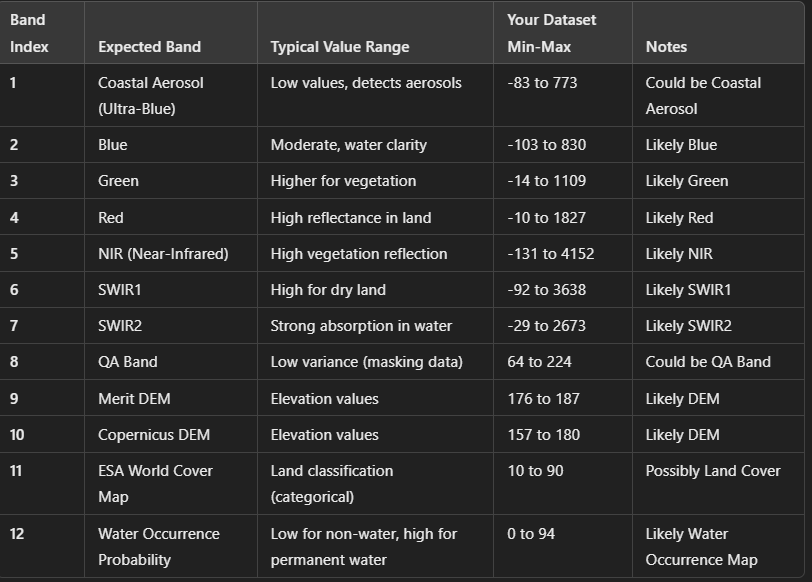

In [216]:
import os
import rasterio
import numpy as np

image_dir = "/kaggle/input/water-segmentation1/data/images"
tif_files = [f for f in os.listdir(image_dir) if f.endswith(".tif")]
if not tif_files:
    raise FileNotFoundError("No TIFF files found in the directory.")

tif_path = os.path.join(image_dir, tif_files[0])
print("Using file:", tif_path)
selected_bands = [3,4,5,6,7,11] 
with rasterio.open(tif_path) as dataset:
    selected_data = np.stack([dataset.read(b) for b in selected_bands], axis=0)
print("Extracted Data Shape:", selected_data.shape)


Using file: /kaggle/input/water-segmentation1/data/images/274.tif
Extracted Data Shape: (6, 128, 128)


In [217]:
image_dir="/kaggle/input/water-segmentation1/data/images"
label_dir="/kaggle/input/water-segmentation1/data/labels"

image_files=sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
label_files=sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])

print("Sample Image Files:",image_files[:5])
print("Sample Label Files:",label_files[:5])

Sample Image Files: ['0.tif', '1.tif', '10.tif', '100.tif', '101.tif']
Sample Label Files: ['0.png', '1.png', '10.png', '100.png', '101.png']


### Train Valid Split

In [218]:
image_files=sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
label_files=sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])

image_names=os.path.splitext(f)[0] for f in image_files}
label_names{os.path.splitext(f)[0] for f in label_files}

valid_names=image_names & label_names 
data=[(os.path.join(image_dir, f"{name}.tif"), os.path.join(label_dir, f"{name}.png")) for name in valid_names]
random.shuffle(data)
train_data,val_data=train_test_split(data, test_size=0.3, random_state=42)

train_images,train_labels=zip(*train_data) if train_data else ([], [])
val_images,val_labels =zip(*val_data) if val_data else ([], [])

train_dataset=tf.data.Dataset.from_tensor_slices((list(train_images), list(train_labels)))
valid_dataset=tf.data.Dataset.from_tensor_slices((list(val_images), list(val_labels)))

image_path ="/kaggle/input/water-segmentation1/data/images/101.tif"
image=tiff.imread(image_path)
print("Image shape:", image.shape)


Image shape: (128, 128, 12)


## Data Visualization

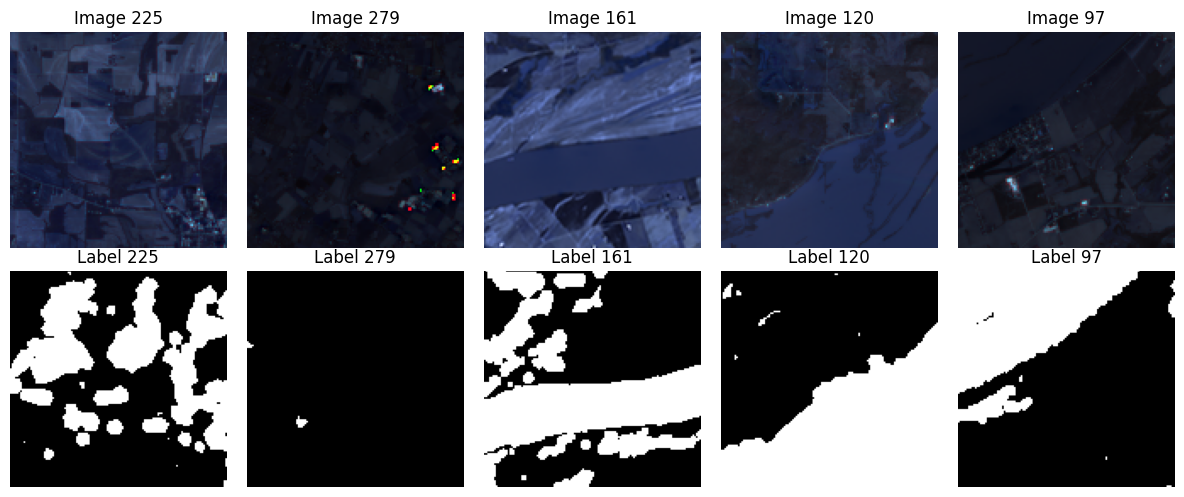

In [219]:
image_files_dict={os.path.splitext(f)[0]: f for f in image_files}
label_files_dict={os.path.splitext(f)[0]: f for f in label_files}
common_keys=sorted(set(image_files_dict.keys()) & set(label_files_dict.keys()))
num_samples=min(5, len(common_keys))  
selected_keys=random.sample(common_keys, num_samples)
fig,axes=plt.subplots(2,num_samples,figsize=(12, 5))
for i, key in enumerate(selected_keys):
    image_path = os.path.join(image_dir, image_files_dict[key])
    label_path = os.path.join(label_dir, label_files_dict[key])
    image = tiff.imread(image_path)
    image_rgb = image[:, :, :3]
    image_rgb = (image_rgb / image_rgb.max() * 255).astype(np.uint8)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    target_size = (128, 128)  # Adjust size as needed
    image_rgb_resized = cv2.resize(image_rgb, target_size, interpolation=cv2.INTER_LINEAR)
    label_resized = cv2.resize(label, target_size, interpolation=cv2.INTER_NEAREST)
    axes[0, i].imshow(image_rgb_resized)
    axes[0, i].set_title(f"Image {key}")
    axes[0, i].axis("off")
    axes[1, i].imshow(label_resized, cmap="gray")
    axes[1, i].set_title(f"Label {key}")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()


## Data Preprocessing

In [220]:
SELECTED_BANDS=[3,4,5] 
def load_and_preprocess(image_path, label_path):
    image_path = image_path.numpy().decode('utf-8')
    label_path = label_path.numpy().decode('utf-8')
    with rasterio.open(image_path) as src:
        image = np.stack([src.read(b) for b in SELECTED_BANDS], axis=-1)  # Shape: (H,W,8)

    resized_bands = [cv2.resize(image[:, :, i], (128, 128), interpolation=cv2.INTER_CUBIC) for i in range(image.shape[-1])]
    image = np.stack(resized_bands, axis=-1)  # Shape: (128,128,8)

    image =image = image.astype(np.float32) / 255.0 
    
    label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
    if label is None:
        raise ValueError(f"Error loading label: {label_path}")

    label = cv2.resize(label, (128, 128), interpolation=cv2.INTER_NEAREST)

    if len(label.shape) == 2:
        label = np.expand_dims(label, axis=-1)
        
    return image, label
def load_and_preprocess_wrapper(image_path, label_path):
    image, label = tf.py_function(
        func=load_and_preprocess, 
        inp=[image_path, label_path], 
        Tout=[tf.float32, tf.float32]
    )
    image.set_shape((128, 128, len(SELECTED_BANDS))) 
    label.set_shape((128, 128, 1))
    return image, label
train_dataset_prep = train_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset_prep = valid_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
BATCH_SIZE = 16
train_dataset_prep = train_dataset_prep.batch(BATCH_SIZE).shuffle(len(train_images)).prefetch(tf.data.AUTOTUNE)
valid_dataset_prep = valid_dataset_prep.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [221]:
train_dataset_prep

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

### Model Performance Metrics

In [ ]:
from tensorflow.keras import backend as K
def iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

def f1_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = K.sum(y_true * y_pred) 
    fp = K.sum(y_pred) - tp  
    fn = K.sum(y_true) - tp  
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    return 2 * (precision * recall) / (precision + recall + K.epsilon())
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    
    return (2. * intersection + smooth) / (union + smooth)

## Modeling


In [223]:
pip install tensorflow==2.10 keras==2.10 segmentation-models==1.0.1

Note: you may need to restart the kernel to use updated packages.


In [224]:
os.environ["SM_FRAMEWORK"] = "tf.keras"  # Set the framework before importing

import segmentation_models as sm
from segmentation_models import Unet  # Import directly
from tensorflow.keras import layers, Model

# Set ResNet backbone
BACKBONE = 'resnet50'


In [225]:
model = Unet(
    backbone_name=BACKBONE, 
    encoder_weights='imagenet',  # Use ImageNet weights
    input_shape=(128, 128, 3),  # Change if using more than 3 bands
    classes=1, 
    activation='sigmoid'
)
    
model.summary()


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, 128, 128, 3)    │              9 │ data[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_378        │ (None, 134, 134, 3)    │              0 │ bn_data[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, 64, 64, 64)     │          9,408 │ zero_padding2d_378[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, 64, 64, 64)     │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, 64, 64, 64)     │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_379        │ (None, 66, 66, 64)     │              0 │ relu0[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling2D)   │ (None, 32, 32, 64)     │              0 │ zero_padding2d_379[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, 32, 32, 64)     │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, 32, 32, 64)     │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, 32, 32, 64)     │          4,096 │ stage1_unit1_relu1[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, 32, 32, 64)     │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, 32, 32, 64)     │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_380        │ (None, 34, 34, 64)     │              0 │ stage1_unit1_relu2[0]… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv2        │ (None, 32, 32, 64)     │         36,864 │ zero_padding2d_380[0]… │
│ (Conv2D)             

 Total params: 32,561,114 (124.21 MB)

 Trainable params: 32,513,556 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

### Model Performance Metrics

In [227]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy",dice_coefficient, iou]
)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_unet_model.keras",  
    monitor="val_iou",  
    mode="max", 
    save_best_only=True,
    verbose=1
)
history = model.fit(
    train_dataset_prep, 
    validation_data=valid_dataset_prep, 
    epochs=100,
    callbacks=[checkpoint_callback]
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6930 - dice_coefficient: 0.4029 - iou: 0.3191 - loss: 0.6176
Epoch 1: val_iou improved from -inf to 0.28692, saving model to best_unet_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6990 - dice_coefficient: 0.4070 - iou: 0.3255 - loss: 0.6094 - val_accuracy: 0.2885 - val_dice_coefficient: 0.4431 - val_iou: 0.2869 - val_loss: 6775.6060
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8869 - dice_coefficient: 0.5806 - iou: 0.5759 - loss: 0.3158
Epoch 2: val_iou did not improve from 0.28692
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8865 - dice_coefficient: 0.5817 - iou: 0.5754 - loss: 0.3157 - val_accuracy: 0.2886 - val_dice_coefficient: 0.4431 - val_iou: 0.2869 - val_loss: 15247.6934
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8988 - dice_coefficient: 0.6265 - iou: 0.6112 - loss: 0.2726
Epoch 3: val_iou did not improve from 0.28692
14/14 ━━━━━━━━━━━━━━━━━━

### Model Performance Visualization

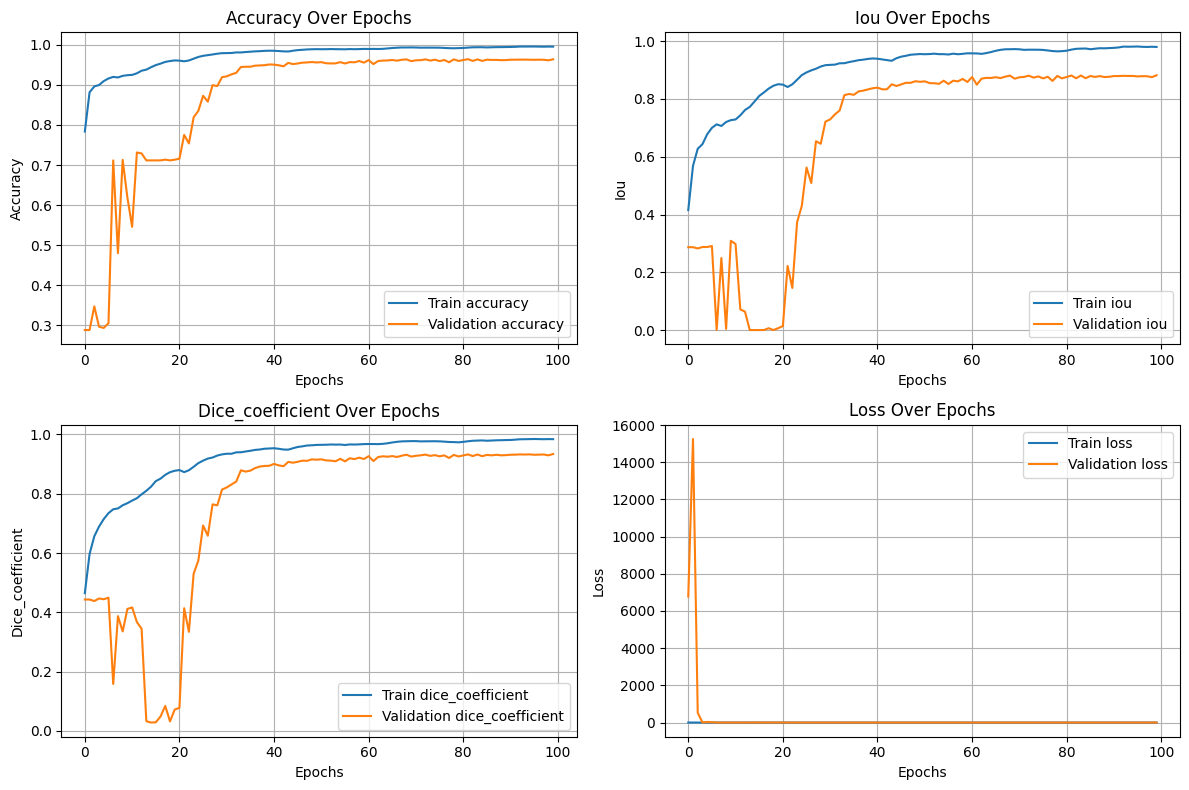

In [233]:
metrics = ["accuracy", "iou", "dice_coefficient", "loss"]
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1) 
    plt.plot(history.history[metric], label=f"Train {metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} Over Epochs")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


## Load Best Model

In [232]:
best_model = tf.keras.models.load_model("best_unet_model.keras", custom_objects={"iou": iou, "dice_coefficient": dice_coefficient})
best_val_iou = max(history.history["val_iou"])  
best_val_dice = max(history.history["val_dice_coefficient"])  
best_val_acc = max(history.history["val_accuracy"])  
best_val_loss = min(history.history["val_loss"])  # Best (lowest) validation loss

print(f"Best Validation IoU: {best_val_iou:.4f}")
print(f"Best Validation Dice Coefficient: {best_val_dice:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
# # Print the summary of the best model
# best_model.summary()

Best Validation IoU: 0.8821
Best Validation Dice Coefficient: 0.9340
Best Validation Accuracy: 0.9638
Best Validation Loss: 0.1440


## Visualize Model Results

TensorFlow version: 2.17.1
Eager execution: True
Trying alternative inference method...
Trying alternative inference method...
Trying alternative inference method...


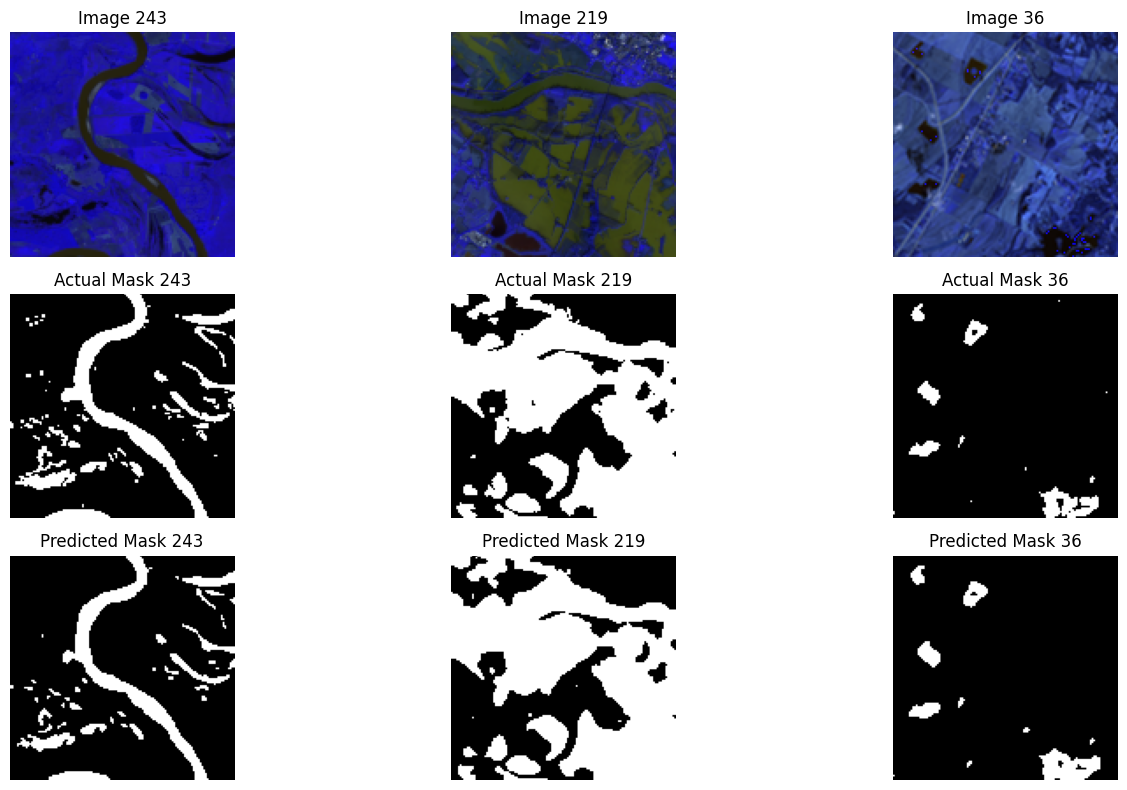

In [230]:
def preprocess_image(image):
    """Normalize the image to [0,1] range for model prediction."""
    image = image.astype(np.float32) / 255.0  # Normalize to 0-1
    return image
print("TensorFlow version:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())
image_files_dict = {os.path.splitext(f)[0]: f for f in image_files}
label_files_dict = {os.path.splitext(f)[0]: f for f in label_files}
common_keys = sorted(set(image_files_dict.keys()) & set(label_files_dict.keys()))
num_samples = min(3, len(common_keys))
selected_keys = random.sample(common_keys, num_samples)
fig, axes = plt.subplots(3, num_samples, figsize=(15, 8))
for i, key in enumerate(selected_keys):
    image_path = os.path.join(image_dir, image_files_dict[key])
    label_path = os.path.join(label_dir, label_files_dict[key])
    image = tiff.imread(image_path)
    SELECTED_BANDS = [3, 4, 5]  
    image_selected = image[:, :, np.array(SELECTED_BANDS) - 1]
    image_rgb = image_selected
    image_rgb = (image_rgb / image_rgb.max() * 255).astype(np.uint8)
    input_image = preprocess_image(image_selected)  
    input_image = np.expand_dims(input_image, axis=0)  
    input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)
    try:
        prediction = best_model.predict(input_image) 
    except Exception as e:
        print("Trying alternative inference method...")

        try:
            prediction = best_model(input_image, training=False).numpy()
        except Exception as e2:
            print("Error using model call:", str(e2))
            prediction = None  

    if prediction is None:
        continue 
    prediction = prediction.squeeze() 
    prediction = (prediction > 0.5).astype(np.uint8)  
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    target_size = (128, 128)  # Adjust size as needed
    image_rgb_resized = cv2.resize(image_rgb, target_size, interpolation=cv2.INTER_LINEAR)
    label_resized = cv2.resize(label, target_size, interpolation=cv2.INTER_NEAREST)
    pred_resized = cv2.resize(prediction, target_size, interpolation=cv2.INTER_NEAREST)
    axes[0, i].imshow(image_rgb_resized)
    axes[0, i].set_title(f"Image {key}")
    axes[0, i].axis("off")
    axes[1, i].imshow(label_resized, cmap="gray")
    axes[1, i].set_title(f"Actual Mask {key}")
    axes[1, i].axis("off")
    axes[2, i].imshow(pred_resized, cmap="gray")
    axes[2, i].set_title(f"Predicted Mask {key}")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()
